In [101]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns



In [102]:
%load_ext IPython.extensions.autoreload
%autoreload 2

import sys
sys.path.insert(0, '/home/patrice/work/ppsp/pycwt')
import pycwt

import hypyp.fnirs as fnirs
from hypyp.wavelet.wavelet_implementations.pywavelets_wavelet import PywaveletsWavelet
from hypyp.wavelet.wavelet_implementations.pycwt_wavelet import PycwtWavelet
from hypyp.wavelet.wavelet_implementations.scipy_wavelet import ScipyWavelet
from hypyp.wavelet.cwt import CWT

The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


## Download and load raw data from disk

In [103]:
# Download data

browser = fnirs.DataBrowser()
browser.download_demo_dataset()


'/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers'

In [104]:
# Get the paths for dyads

paths = [path for path in browser.list_all_files() if 'fathers' in path]

pattern_parent = re.compile(r'.*/parent/.*')

file_path = ''
for path in paths:
    if pattern_parent.match(path) is not None:
        file_path = path
        break
if file_path == '':
    raise RuntimeError('Cannot find a fNIRS file')

print(file_path)
    

/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS01/parent/NIRS-2019-09-28_002.hdr


## Intra subject validation

In [105]:
wavelet_kwargs = dict(disable_caching=True, periods_range=(1, 30))
wavelets = [
    PywaveletsWavelet(wavelet_name='cmor0.5,1', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cmor1,1', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cmor2,1', **wavelet_kwargs), # default
    PywaveletsWavelet(wavelet_name='cmor4,1', **wavelet_kwargs),

    PywaveletsWavelet(wavelet_name='cgau2', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cgau3', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cgau4', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cgau5', **wavelet_kwargs),

    ScipyWavelet(center_frequency=1, **wavelet_kwargs),
    ScipyWavelet(center_frequency=2, **wavelet_kwargs),
    ScipyWavelet(center_frequency=5, **wavelet_kwargs),
    ScipyWavelet(center_frequency=10, **wavelet_kwargs),

    PycwtWavelet(center_frequency=2, **wavelet_kwargs),
    PycwtWavelet(center_frequency=4, **wavelet_kwargs),
    PycwtWavelet(center_frequency=6, **wavelet_kwargs), # default
    PycwtWavelet(center_frequency=10, **wavelet_kwargs),
]

# Prepare a generator for lean code
def wavelets_plot_iterator():
    cols = 4
    rows = int(np.ceil(len(wavelets) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    axes = np.atleast_2d(axes)
    for i, wavelet in enumerate(wavelets):
        row = i // cols
        col = i % cols
        ax = axes[row][col]
        yield wavelet, ax




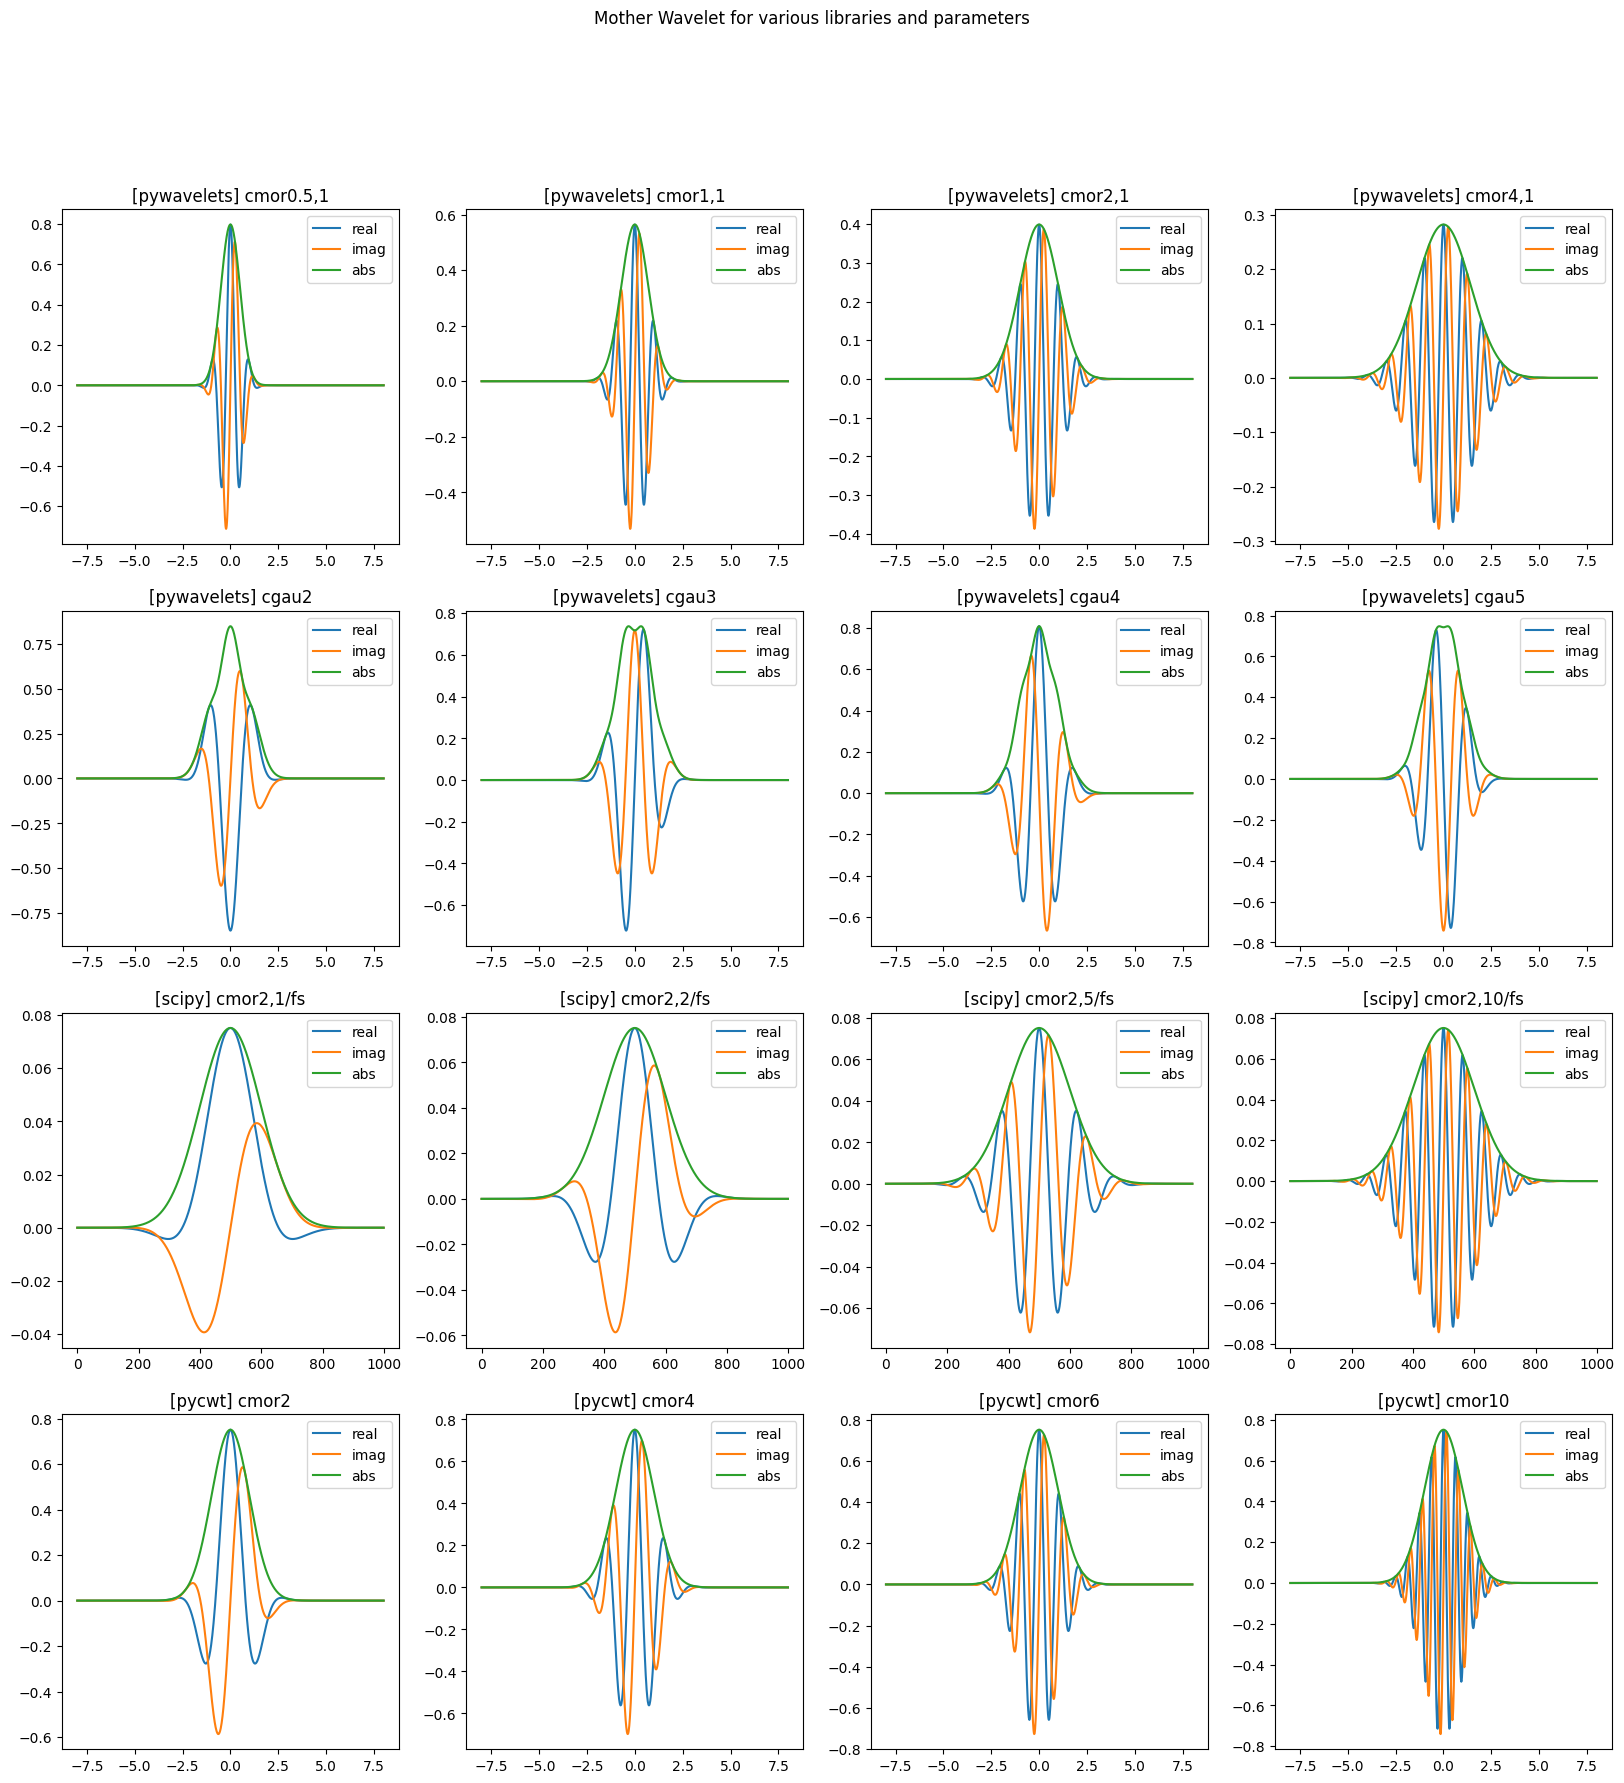

In [106]:

for wavelet, ax in wavelets_plot_iterator():
    wavelet.plot_mother_wavelet(ax=ax)
    ax.set_title(f'[{wavelet.wavelet_library}] {wavelet.wavelet_name}')
_ = ax.get_figure().suptitle('Mother Wavelet for various libraries and parameters')


In [107]:
subject = fnirs.Subject(label='Subject 0', tasks_time_range=[('first_minute', 0, 60)]).load_file(file_path, fnirs.MnePreprocessor())
intra = fnirs.Dyad(subject, subject, label=f'intra')
# take one pair
pair = intra.get_pairs(subject, subject)[1]


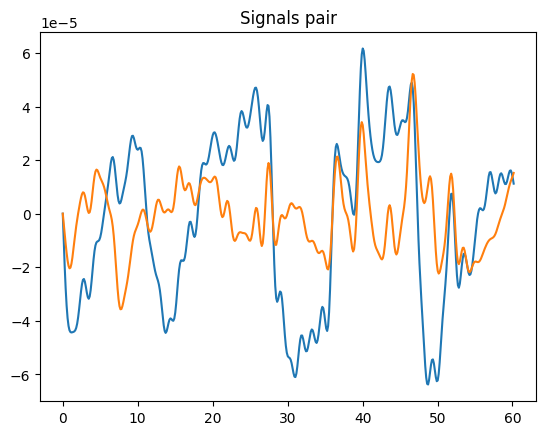

In [108]:
plt.plot(pair.x, pair.y1)
plt.plot(pair.x, pair.y2)
plt.title('Signals pair')
plt.show()


In [ ]:
for wavelet, ax in wavelets_plot_iterator():
    cwt = wavelet.cwt(pair.y1, pair.dt)
    cwt.plot(ax=ax, show_colorbar=False)
    ax.set_title(f'CWT [{wavelet.wavelet_library}] {wavelet.wavelet_name}')
    ax.get_figure().suptitle('Continuous Wavelet Transform of channel 1')
plt.show()

for wavelet, ax in wavelets_plot_iterator():
    cwt = wavelet.cwt(pair.y2, pair.dt)
    cwt.plot(ax=ax, show_colorbar=False)
    ax.set_title(f'CWT [{wavelet.wavelet_library}] {wavelet.wavelet_name}')
    ax.get_figure().suptitle('Continuous Wavelet Transform of channel 2')
plt.show()

## Compare soothed CWTs


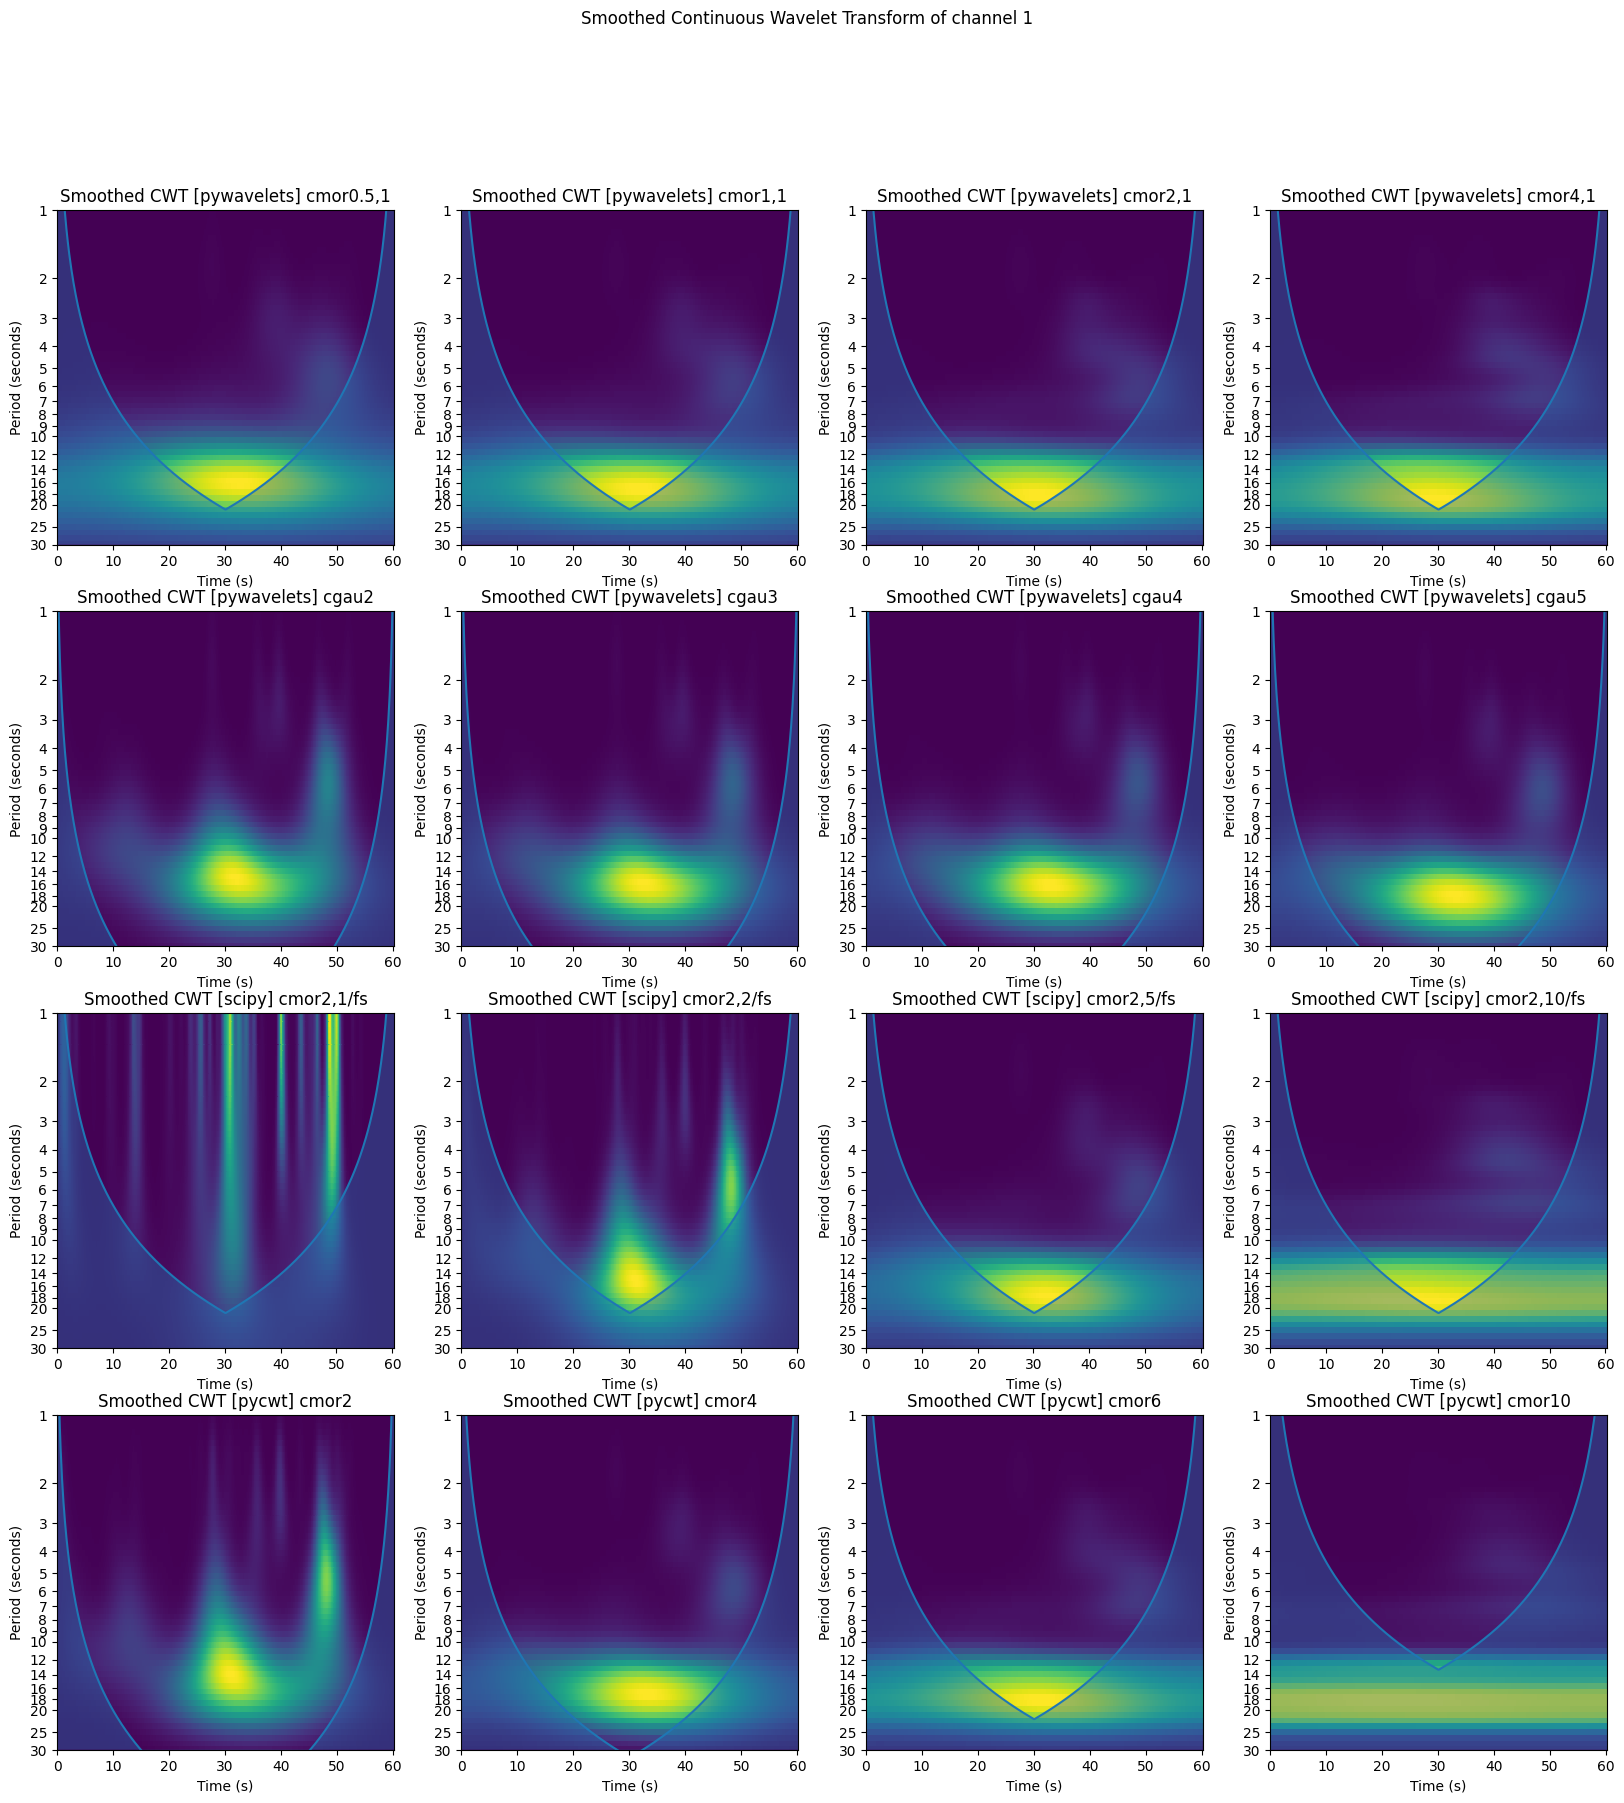

In [ ]:
for wavelet, ax in wavelets_plot_iterator():
    cwt = wavelet.cwt(pair.y1, pair.dt)

    scales = np.ones([1, len(pair.y1)]) * cwt.scales[:, None]
    try:
        smooted = wavelet.smoothing(np.abs(cwt.W) ** 2 / scales, cwt.dt, 1/12, cwt.scales)
        cwt_smoothed = CWT(smooted**2, cwt.times, cwt.scales, cwt.periods, cwt.coi)
        cwt_smoothed.plot(ax=ax, show_colorbar=False)
        ax.set_title(f'Smoothed CWT [{wavelet.wavelet_library}] {wavelet.wavelet_name}')
        ax.get_figure().suptitle('Smoothed Continuous Wavelet Transform of channel 1')
    except:
        pass
plt.show()



/home/patrice/.cache/pypoetry/virtualenvs/hypyp-3IxKTwjU-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/patrice/.cache/pypoetry/virtualenvs/hypyp-3IxKTwjU-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


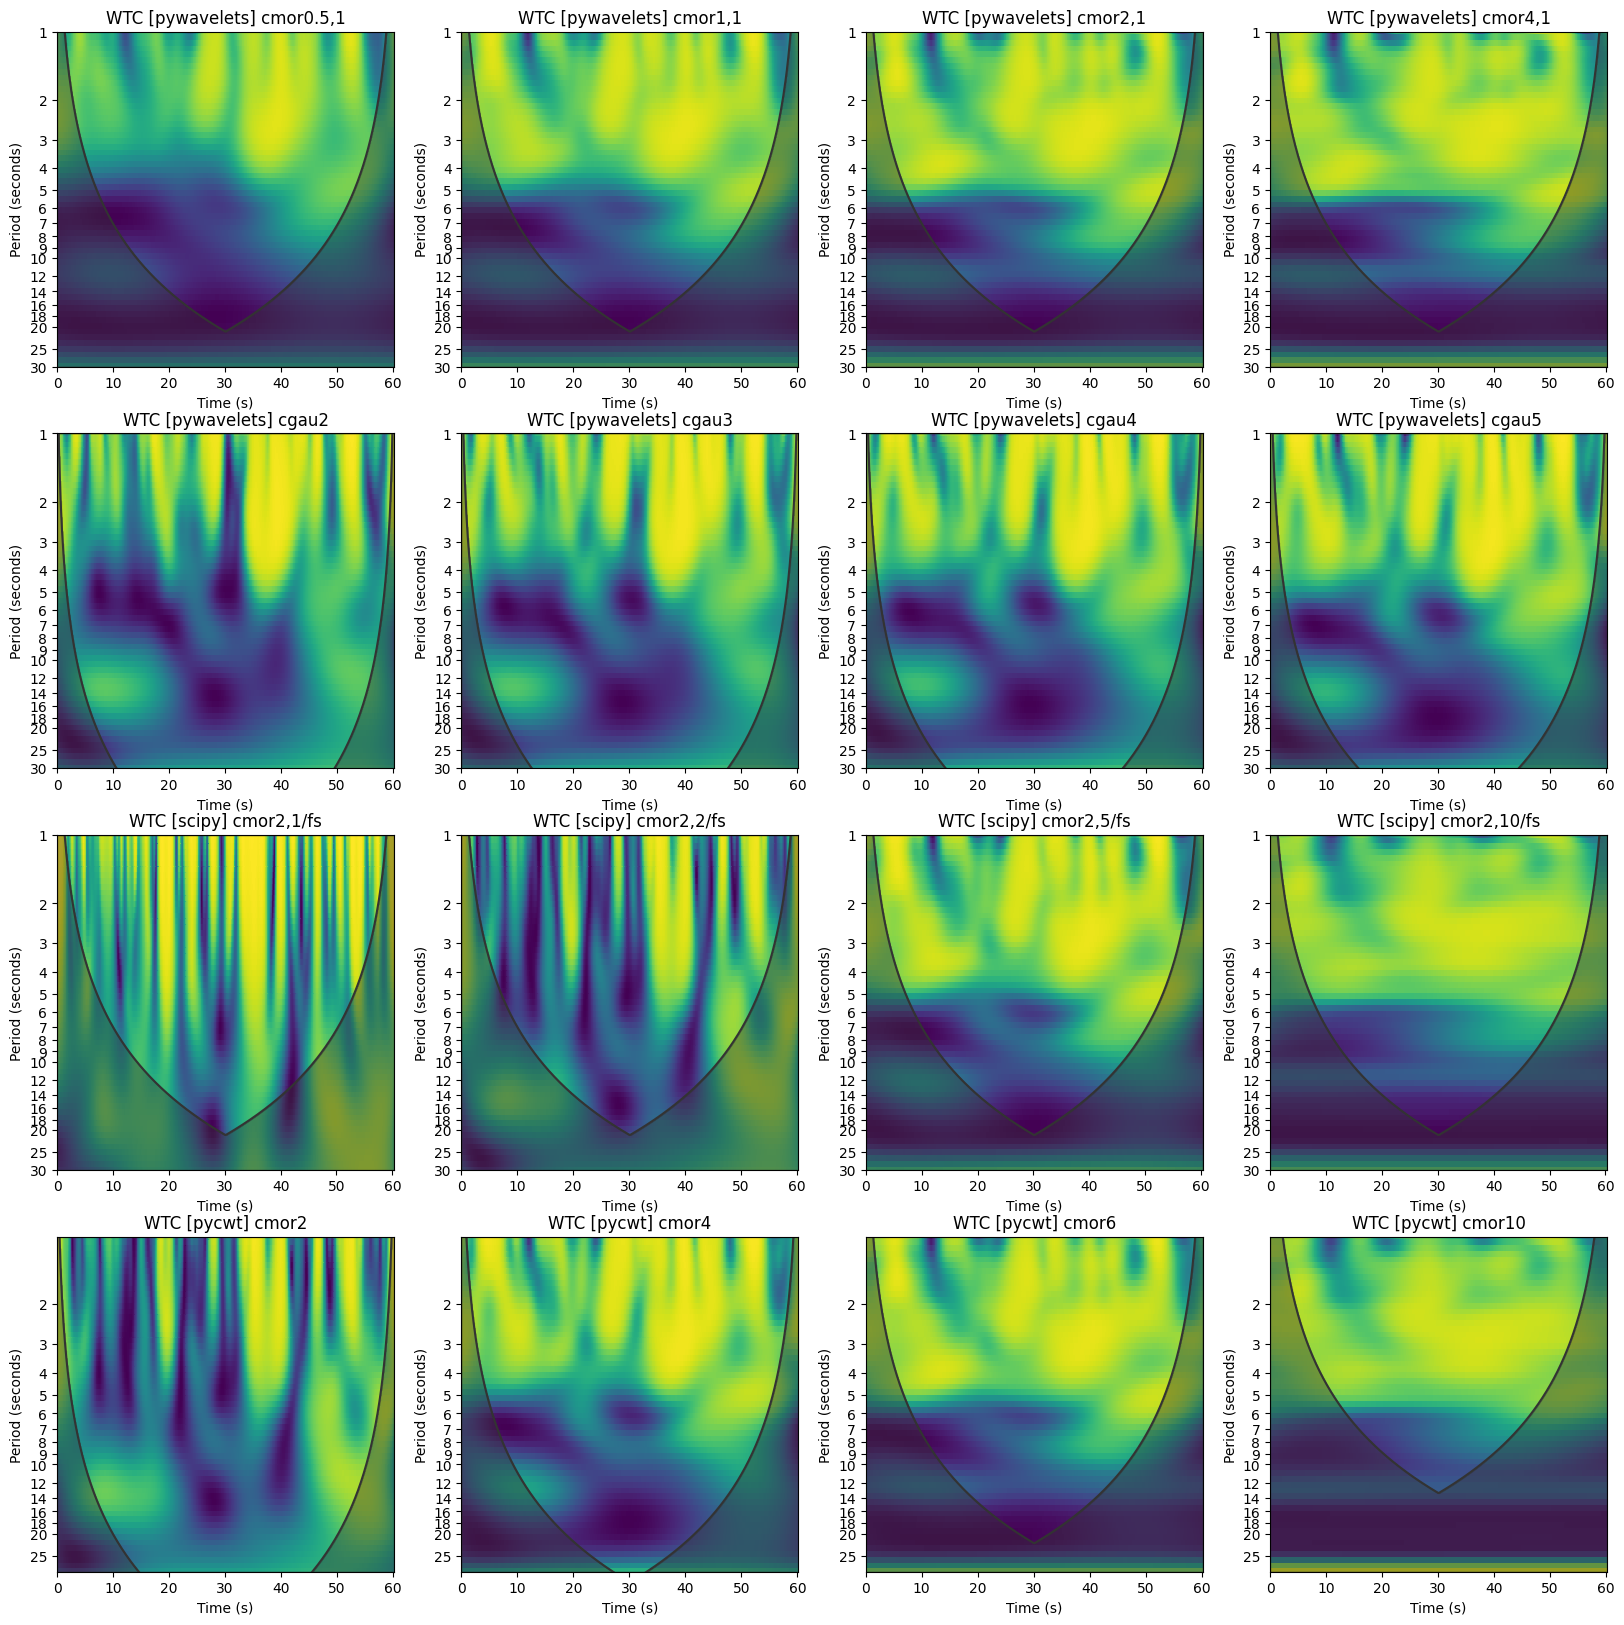

In [ ]:
for wavelet, ax in wavelets_plot_iterator():
    wtc = wavelet.wtc(pair)
    wtc.plot(ax=ax, show_colorbar=False)
    ax.set_title(f'WTC [{wavelet.wavelet_library}] {wavelet.wavelet_name}')


In [100]:

intras = []
i = 0
for wavelet in wavelets:
    intra = fnirs.Dyad(subject, subject, label=f'intra [{wavelet.wavelet_library}] {wavelet.wavelet_name}')
    intra.compute_wtcs(wavelet=wavelet, ch_match='hbo', verbose=True)
    intras.append(intra)
    i += 1
    if i > 2:
        break


Running Wavelet Coherence for dyad "intra [pywavelets] cmor0.5,1" on pair "first_minute - S1_D1 hbo - S1_D1 hbo"
Running Wavelet Coherence for dyad "intra [pywavelets] cmor0.5,1" on pair "first_minute - S1_D1 hbo - S1_D2 hbo"
Running Wavelet Coherence for dyad "intra [pywavelets] cmor0.5,1" on pair "first_minute - S1_D1 hbo - S2_D1 hbo"
Running Wavelet Coherence for dyad "intra [pywavelets] cmor0.5,1" on pair "first_minute - S1_D1 hbo - S2_D3 hbo"
Running Wavelet Coherence for dyad "intra [pywavelets] cmor0.5,1" on pair "first_minute - S1_D1 hbo - S3_D2 hbo"
Running Wavelet Coherence for dyad "intra [pywavelets] cmor0.5,1" on pair "first_minute - S1_D1 hbo - S3_D3 hbo"
Running Wavelet Coherence for dyad "intra [pywavelets] cmor0.5,1" on pair "first_minute - S1_D1 hbo - S3_D4 hbo"
Running Wavelet Coherence for dyad "intra [pywavelets] cmor0.5,1" on pair "first_minute - S1_D1 hbo - S4_D2 hbo"
Running Wavelet Coherence for dyad "intra [pywavelets] cmor0.5,1" on pair "first_minute - S1_D1 

ValueError: 19 columns passed, passed data had 21 columns

Text(0.5, 1.0, 'Comparison of coherence')

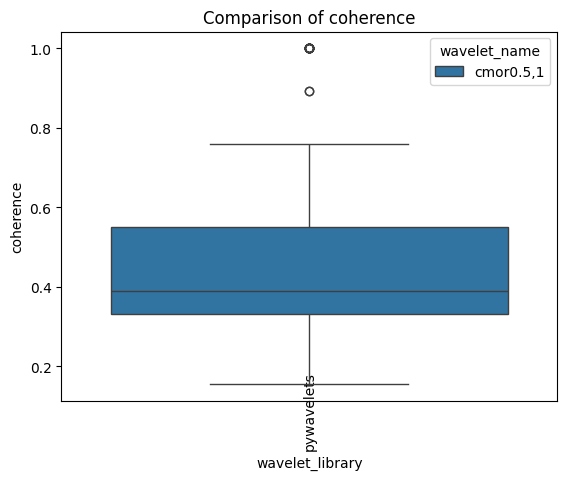

In [99]:

df = fnirs.Cohort(intras).df
df

sns.boxplot(data=df, x='wavelet_library', y='coherence', hue='wavelet_name')

# Customize the plot
plt.xticks(rotation=90, ha='center', va='center')  # Rotate x-axis labels
plt.title('Comparison of coherence')  # Set the title
